In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from xarray import open_dataset

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Arrow, Polygon
from matplotlib.lines import Line2D
import cmocean as cmo

import string

In [2]:
fs_small = 12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [3]:
from scipy.interpolate import interp1d
def interp(xp, yp, xi):
    
    xp = np.ma.masked_invalid(xp)
    yp = np.ma.masked_invalid(yp)
    
    mask = xp.mask | yp.mask
        
    f = interp1d(xp[~mask], yp[~mask], bounds_error=False, kind='linear')
    
    return f(xi)

In [4]:
savefig = False

fs_small = 20 # 20
fs_large = 22 # 22
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=fs_small, titlesize=fs_small)
plt.rc('font', size=fs_small)


In [5]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# load gem
input_file_gem = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')

# load quasi-geostrophic vorticity terms
input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_qgvb.nc')
qgvb = open_dataset(input_file_qgvb, group='QGVB')

input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_qgvb_ctd.nc')
qgvb_ctd = open_dataset(input_file_qgvb, group='CTD')

# load altimetry/ ssh data
input_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_gw.nc')
ssh = open_dataset(input_file_gw)

In [6]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

timevoy = slice('1998-03-12', '1998-03-28')


# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

# station number of outliers in GEM
outliers = [1, 2, 9, 10, 11, 12, 27, 35, 45, 46, 47, 75, 76, 77, 78, 101]
ioutliers = np.array([istat for istat, station in enumerate(ctd['station']) if station in outliers])

# watermass definitions
watermass = {
    'ML': (26.4, 26.8),
    'SAMW': (26.8, 27.0),
    'AAIW': (27.0, 27.7),
    'UCDW': (27.7, 27.98),
}
density_levels = np.unique([value for value in watermass.values()])

# attributes of variables
attr = {'pt' : ('Potential Temperature', cmo.cm.thermal, (2.25, 12.25), cmo.cm.balance, (-1, 1, 16)), 
        'CT' : ('Conservative Temperature', cmo.cm.thermal, (2, 12), cmo.cm.balance, (-0.5, 0.5, 21)), 
        'SA': ('Absolute Salinity', cmo.cm.haline, (34, 35), cmo.cm.delta, (-0.2, 0.2, 26)),
        'sigma0': ('Potential density', cmo.cm.dense, (26.4, 27.7), cmo.cm.curl, (-0.05, 0.05, 16)),
        'gamman': ('Neutral density', cmo.cm.dense, (26.35, 27.95), cmo.cm.diff_r, (-0.05, 0.05, 16))
       }

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


## Calculate terms in Taylor series of temperature anomalies

In [7]:
var = 'CT'

# transformation 1: from p to z
z = np.ma.masked_invalid(ctd['z'])
zi = np.linspace(z.max(), z.min(), ctd['p'].size)
zgrd = np.broadcast_to(zi, ctd['z'].shape)

CT_z = np.ma.masked_all(ctd[var].shape)
# dCTdz_z, dCTdz_gem_z = CT_z.copy(), CT_z.copy()
CT_gem_z, gamman_z, gamman_gem_z = CT_z.copy(), CT_z.copy(), CT_z.copy()
for i in range(len(ctd['station'])):
    CT_z[i,] = interp(ctd['z'][i,], ctd[var][i,], zi)
    CT_gem_z[i,] = interp(ctd['z'][i,], gem[var][i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
    
    gamman_z[i,] = interp(ctd['z'][i,], ctd['gamman'][i,], zi)
    gamman_gem_z[i,] = interp(ctd['z'][i,], gem['gamman'][i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
    
dCTdz_z = np.gradient(CT_z)[1] / np.gradient(zgrd)[1]
dCTdz_gem_z = np.gradient(CT_gem_z)[1] / np.gradient(zgrd)[1]

CT_prime_z = CT_z - CT_gem_z

# transformation 2: from z to gamman
gn = np.ma.masked_invalid(ctd['gamman'])
gni = np.linspace(gn.min(), gn.max(), ctd['p'].size)

CT_gn, CT_gem_gn = np.ma.masked_all(ctd[var].shape), np.ma.masked_all(ctd[var].shape)
SA_gn, SA_gem_gn = CT_gn.copy(), CT_gn.copy()
h_gn, h_gem_gn = CT_gn.copy(), CT_gn.copy()
for i in range(len(ctd['station'])):
    CT_gn[i,] = interp(ctd['gamman'][i,], ctd['CT'][i,], gni)
    CT_gem_gn[i,] = interp(ctd['gamman'][i,], gem['CT'][i,], gni) if i != 34 else np.nan * np.ones(zi.shape)

    SA_gn[i,] = interp(ctd['gamman'][i,], ctd['SA'][i,], gni)
    SA_gem_gn[i,] = interp(ctd['gamman'][i,], gem['SA'][i,], gni) if i != 34 else np.nan * np.ones(ctd['p'].shape)
    
    h_gn[i,] = interp(ctd['gamman'][i,], ctd['z'][i,], gni)
    h_gem_gn[i,] = interp(gem['gamman'][i,], ctd['z'][i], gni) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_gn = CT_gn - CT_gem_gn
SA_prime_gn = SA_gn - SA_gem_gn
h_prime_gn = h_gn - h_gem_gn
    
# transformation 3: from z to zm
zm = (h_gn + h_gem_gn) / 2

CT_zm = np.ma.masked_all(ctd[var].shape)
CT_gem_zm = CT_zm.copy()
dCTdz_zm, dCTdz_gem_zm = CT_zm.copy(), CT_zm.copy()
for i in range(len(ctd['station'])):
    CT_zm[i,] = interp(zi, CT_z[i,], zm[i,].data)
    CT_gem_zm[i,] = interp(zi, CT_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)
    
    dCTdz_zm[i,] = interp(zi, dCTdz_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)
    dCTdz_gem_zm[i,] = interp(zi, dCTdz_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_zm = CT_zm - CT_gem_zm
dCTdz_prime_zm = dCTdz_zm - dCTdz_gem_zm
# dCTdz_zm = np.gradient(CT_gem_zm)[1] / np.gradient(zm)[1]



## Calculate dynamic height and neutral density averages at each transect

In [8]:
Dmin, Dmax = [], []
idx_deep = []
for transect in list(transects.keys()):
    
    stations = np.array(list(reversed(transects[transect])))   
    mask = [station not in ioutliers for station in stations]
    
    Dmin.append(D[stations[mask]].min()), Dmax.append(D[stations[mask]].max())
    
    for station in stations[mask]:
        idx_deep.append(max([i for (i, j) in enumerate(CT_prime_gn[station]) if np.isfinite(j)]))

Dmin, Dmax = max(Dmin), min(Dmax)
dD = Dmax - Dmin

idx_deep = min(idx_deep)

print('Dynamic Height integration limits: ', Dmin, Dmax, dD)
print('Neutral density lower integration limit: ', gni[idx_deep])

idx = (np.abs(gni - 27.3)).argmin()
idx_ml = (np.abs(gni - watermass['ML'][1])).argmin()
print('Neutral density middle integration limit: ', gni[idx])
print('Neutral density upper integration limit: ', gni[idx_ml])

dgamma = np.gradient(gni)
CT_inc = CT_prime_gn * dgamma
tot_CT_upper = np.nansum(CT_inc[:, idx_ml:idx], 1)
tot_CT_lower = np.nansum(CT_inc[:, idx:idx_deep], 1)
tot_CT_comb = np.nansum(CT_inc[:, idx_ml:idx_deep], 1)

tot_CT_prime_gn = {}
for transect in list(transects.keys()):
    
    stations = np.array(list(reversed(transects[transect])))   
    mask = [station not in ioutliers for station in stations]
    
#     print(D[stations[mask]])
#     dD = np.gradient(D[stations[mask]])
    tot_CT_prime_gn[transect] = [
        np.sum(tot_CT_upper[stations[mask]] * dD),
        np.sum(tot_CT_lower[stations[mask]] * dD),
        np.sum(tot_CT_comb[stations[mask]] * dD),
        np.sum(qgvb_ctd['divag'][stations[mask]] * dD).values
    ]

Dynamic Height integration limits:  1.3165198019283124 1.551125971578186 0.23460616964987357
Neutral density lower integration limit:  27.697277069091797
Neutral density middle integration limit:  27.300936381022137
Neutral density upper integration limit:  26.79986317952474


In [9]:
attrs = {
    'upper water column ($ %s \leq \gamma \leq %s$)': ('tab:orange', ':', 'o', (round(gni[idx_ml],2), round(gni[idx],2))),
    'lower water column ($ %s < \gamma < %s$)': ('tab:blue', '--', 'D', (round(gni[idx],2), round(gni[idx_deep],2))),
    'combined ($ %s \leq \gamma < %s$)': ('tab:gray', '-', 'v', (round(gni[idx_ml],2), round(gni[idx_deep],2))),
    'sea surface hor. divergence': ('deeppink', '-.', 's')#'forestgreen'
}

upper water column ($ %s \leq \gamma \leq %s$) (26.8, 27.3)
lower water column ($ %s < \gamma < %s$) (27.3, 27.7)
combined ($ %s \leq \gamma < %s$) (26.8, 27.7)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


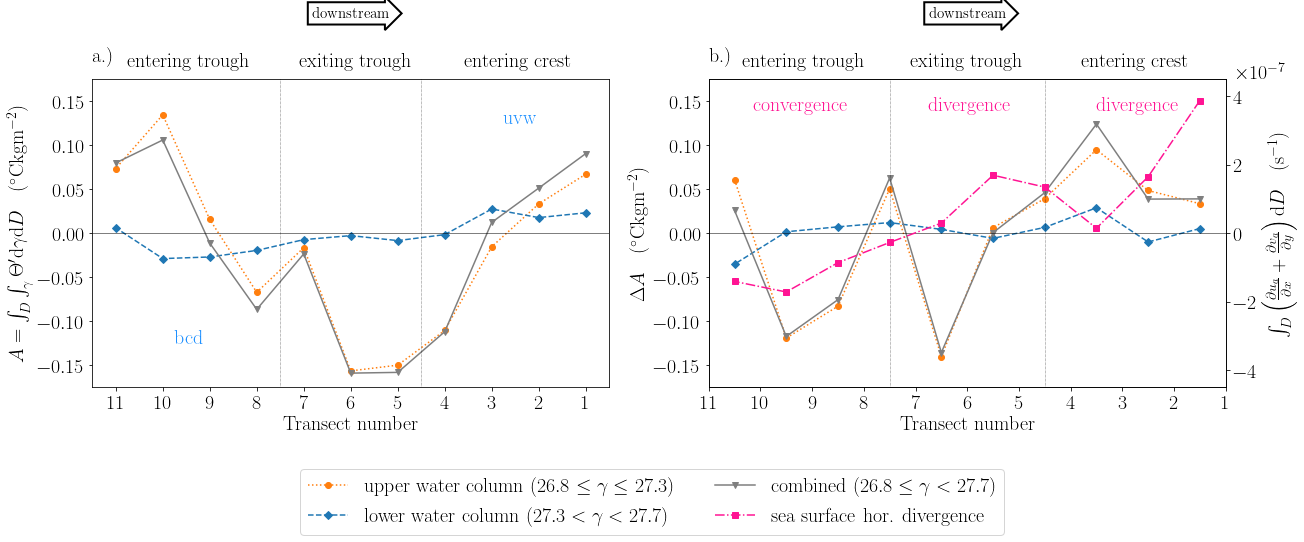

In [10]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), constrained_layout=True)

## First Panel

x = list(tot_CT_prime_gn.keys())
xlabels = ['Transect %i' % i for i in x]

for n, key in enumerate(list(attrs.keys())[:-1]):
    print(key, attrs[key][3])
    A = [i[n] for i in tot_CT_prime_gn.values()]
    ax[0].plot(x, A, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2], label=key%attrs[key][3])
ax[0].set_ylabel(r"$A = \int_D\int_\gamma\Theta'\mathrm{d}\gamma\mathrm{d}D \quad \mathrm{(^\circ C kgm^{-2})}$")

## Second Panel

### left y-axis
for n, key in enumerate(list(attrs.keys())[:-1]):
    dx = [x[i] + (x[i+1] - x[i])/2 for i in range(len(x)-1)]
    A = [i[n] for i in tot_CT_prime_gn.values()]
    dA = np.flip([A[i] - A[i+1] for i in reversed(range(len(A)-1))])

    ax[1].plot(dx, dA, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2])#, label=key
ax[1].set_ylabel(r"$\Delta A \quad \mathrm{(^\circ C kgm^{-2})}$")

### right y-axis
key = 'sea surface hor. divergence'
ax2 = ax[1].twinx()
s = [i[3] for i in tot_CT_prime_gn.values()]
si = np.interp(dx, x, s)
ax2.plot(dx, si, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2], label=key)
ax2.set_ylim(-4.5e-7, 4.5e-7)
ax2.yaxis.offsetText.set_position((1.12, 1))
ax2.set_ylabel(r"$\int_D \left(\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}\right) \mathrm{d}D \quad \mathrm{(s^{-1})}$")

# Formatting axes
for n in range(len(ax)):
    ax[n].set_xticks(x)
    ax[n].set_xlabel('Transect number')
#     ax[n].set_xticklabels(xlabels, rotation=45, ha='right')
    ax[n].invert_xaxis()    
    ax[n].set_ylim(-0.175, 0.175)
    ax[n].axhline(color='k', lw=0.5)
    ax[n].axvline(7.5, color='k', linestyle=':', lw=0.5)
    ax[n].axvline(4.5, color='k', linestyle=':', lw=0.5)
    ax[n].text(10.75 - n*0.4, 0.19, 'entering trough')
    
#     ax[n].annotate('ds', xy=(0.7, 1.1), xycoords='axes fraction', xytext=(0.5, 1.1),
#                    arrowprops=dict(arrowstyle="->", color='b'))
    ax[n].text(6, 0.25, "downstream", ha="center", va="center", size=15,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="none", ec="k", lw=2))

    ax[n].text(7.1, 0.19, 'exiting trough')
    ax[n].text(3.6 + n*0.2, 0.19, 'entering crest')
    
    # panel numbering
    ax[n].text(11.5 - n*0.5, 0.195, string.ascii_lowercase[n] + '.)')

# 
ax[0].text(9.75, -0.125, 'bcd', color='dodgerblue')
ax[0].text(2.75, 0.125, 'uvw', color='dodgerblue')

ax[1].text(10.15, 0.14, 'convergence', color='deeppink')
ax[1].text(6.75, 0.14, 'divergence', color='deeppink')
ax[1].text(3.5, 0.14, 'divergence', color='deeppink')


fig.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=2)
        
# if savefig:
#     fignumber = '09_'
#     figname = 'summary-spice-anomaly-div'
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), transparent=True, bbox_inches='tight')


In [11]:
avg_CT_prime_gn = np.ma.masked_all((len(transects.keys()), gni.size))

for its, transect in enumerate(list(transects.keys())):
   
    stations = np.array(list(reversed(transects[transect])))   
    mask = [station not in ioutliers for station in stations]
    
    idx = [station for station in stations[mask] if Dmin <= D[station] <= Dmax]
       
    avg_CT_prime_gn[its] = np.nanmean(CT_prime_gn[idx], axis=0)


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# # https://www.epochconverter.com/
# start_ts1 = ctd['time'][transects[1][-1]][0,]
# end_ts2 = ctd['time'][transects[2][-1]][1,]
# print(start_ts1,end_ts2)

# timevoy = slice('1998-03-12', '1998-03-17')

# start_ts8 = ctd['time'][transects[8][-1]][0,]
# end_ts11 = ctd['time'][transects[11][-1]][1,]
# print(start_ts8, end_ts11)

# timevoy = slice('1998-03-23', '1998-03-27')

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


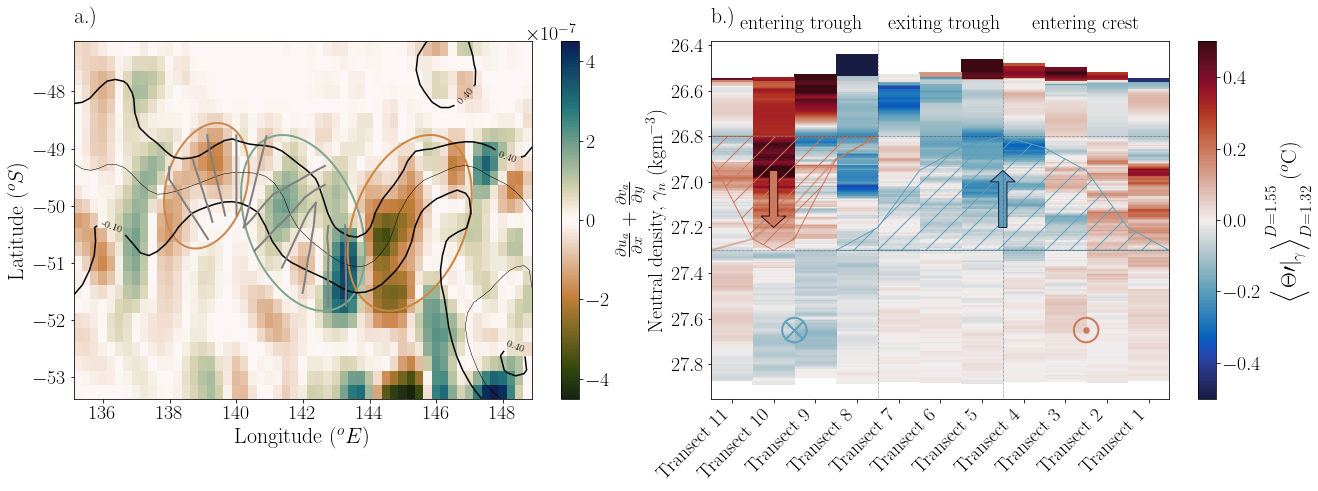

In [13]:
vmin, vmax = -4.5e-7, 4.5e-7
ssh_contours = np.linspace(-0.1, 0.4, 3)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
fig.tight_layout()

# Panel 1
manual = [(144, -52), (144, -51.5), (145, -51), (145, -50), (145, -48.6)]
pcol = ax[0].pcolor(qgvb.longitude, qgvb.latitude, qgvb.divag.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.tarn)
cbar = plt.colorbar(pcol, ax=ax[0])
cbar.ax.set_ylabel(r'$\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}$', fontsize=fs_large)

# Plot steamlines
ct = ax[0].contour(ssh.longitude, ssh.latitude,
                   ssh.adt.sel(time=timevoy).mean('time'),
                   ssh_contours, colors='k', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(ssh_contours):
    if b in ssh_contours[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax[0].clabel(ct, ssh_contours[0::2], inline=1, fontsize=10, fmt='%.2f')
# ax.clabel(ct, [Dmin, Dmax], inline=1, fontsize=10, fmt='%.2f')

# Plot transects
for transect in transects.keys():
    istations = np.array(transects[transect])
    ax[0].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0],
               '-', color='gray', lw=2)
    
# plot Ellipse 1
ellps = Ellipse(xy=(139.1, -49.65), width=2.7, height=2, angle=30, fill=False, lw=2)
# ellps.set_facecolor(cmo.cm.tarn(78, 0.1))
ellps.set_edgecolor(cmo.cm.tarn(78))
ax[0].add_artist(ellps)

# plot Ellipse 2
ellps = Ellipse(xy=(142, -50.3), width=4, height=2.7, angle=-30, fill=False, lw=2)
# ellps.set_facecolor(mcolors.to_rgba('teal', 0.1))
ellps.set_edgecolor(cmo.cm.tarn(178))
ax[0].add_artist(ellps)

# plot Ellipse 3
ellps = Ellipse(xy=(145.2, -50.3), width=4, height=2.7, angle=30, fill=False, lw=2)
ax[0].add_artist(ellps)
ellps.set_facecolor(mcolors.to_rgba('peru', 0.1))
ellps.set_edgecolor(mcolors.to_rgba('peru', 1))

ax[0].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax[0].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)


# Panel 2
var='CT'
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)
pcol = ax[1].pcolormesh(x, gni, avg_CT_prime_gn.T, 
                        cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1], shading='auto')

cbar = plt.colorbar(pcol, ax=ax[1])
cbar.ax.set_ylabel(r'$\left <\left.\Theta\prime\right|_{\gamma} \right >_{D=%s}^{D=%s}$ ($^o$C)' %(round(Dmin,2), round(Dmax,2)), fontsize=fs_large)

# Cones
# warm cone
linex, liney = np.array([[11.5, 10.5, 9.5, 8.5, 7.5], [27.3, 27.25, 27.1, 26.9, 26.8]])
line = Line2D(linex, liney, lw=2, color=cmo.cm.balance(178), alpha=0.5)
ax[1].add_line(line)

poly = Polygon([[11.5, 26.8], [11.5, 26.9], [10.5, 27.25], [10, 27.3], [9.5, 27.25], [8.5, 26.9], [7.5, 26.8]], 
               closed=True, fill=False, hatch='/')
poly.set_edgecolor(cmo.cm.balance(178))
ax[1].add_patch(poly)

# cold cone
# linex, liney = np.array([[8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5], [27.3, 27.2, 26.9, 26.8, 26.75, 26.8, 26.9, 27.2, 27.3]])
# line = Line2D(linex, liney, lw=2, color=cmo.cm.balance(78), alpha=0.5)
# ax[1].add_line(line)
poly = Polygon([[8.5, 27.3], [7.5, 27.2], [6.5, 26.95], [5.5, 26.85], [4.5, 26.8], 
                [3.5, 26.85], [2.5, 26.95], [1.5, 27.2], [0.5, 27.3]], closed=True,
                      fill=False, hatch='/')
poly.set_edgecolor(cmo.cm.balance(78))
ax[1].add_patch(poly)

# Add vector symbols
# upper water column
arrow_up = Arrow(x=10, y=26.95, dx=0, dy=0.25, width=1)
arrow_up.set_facecolor(cmo.cm.balance(178))
arrow_up.set_edgecolor(cmo.cm.balance(256))
ax[1].add_artist(arrow_up)

arrow_down = Arrow(x=4.5, y=27.2, dx=0, dy=-0.25, width=1)
arrow_down.set_facecolor(cmo.cm.balance(78))
arrow_down.set_edgecolor(cmo.cm.balance(0))
ax[1].add_artist(arrow_down)

# lower water column
circ = plt.scatter(9.5, 27.65, s=600, edgecolors=cmo.cm.balance(78), facecolors='none', marker='o', linewidths=2)
cross = plt.scatter(9.5, 27.65, s=300, color=cmo.cm.balance(78), marker='x', linewidths=2)

circ = plt.scatter(2.5, 27.65, s=600, edgecolors=cmo.cm.balance(178), facecolors='none', marker='o', linewidths=2)
dot = plt.scatter(2.5, 27.65, s=20, edgecolors=cmo.cm.balance(178), facecolors=cmo.cm.balance(178), marker='o', linewidths=2)

ax[1].set_xticks(x)
ax[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=fs_small)
ax[1].invert_xaxis()
ax[1].invert_yaxis()
ax[1].axvline(4.5, color='k', linestyle=':', linewidth=0.5)
ax[1].axvline(7.5, color='k', linestyle=':', linewidth=0.5)
ax[1].axhline(26.8, color='k', linestyle=':', linewidth=0.5)
ax[1].axhline(27.3, color='k', linestyle=':', linewidth=0.5)
ax[1].text(10.8, 26.33, 'entering trough', fontsize=fs_small)
ax[1].text(7.25, 26.33, 'exiting trough', fontsize=fs_small)
ax[1].text(3.8, 26.33, 'entering crest', fontsize=fs_small)
ax[1].set_ylabel(r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', fontsize=fs_small)

iax = 0
for i in range(len(ax)):
    ax[i].text(0, 1.05, string.ascii_lowercase[iax] + '.)', transform=ax[i].transAxes, 
           size=fs_large, weight='bold')
    iax+=1

# if savefig:
#     fignumber = '10_'
#     figname = 'schematic-cyclogenesis'
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), transparent=True, bbox_inches='tight')

In [14]:
np.linspace(26.4, 28.0, 9)

array([26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. ])

upper water column ($ %s \leq \gamma \leq %s$) (26.8, 27.3)
lower water column ($ %s < \gamma < %s$) (27.3, 27.7)
combined ($ %s \leq \gamma < %s$) (26.8, 27.7)


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


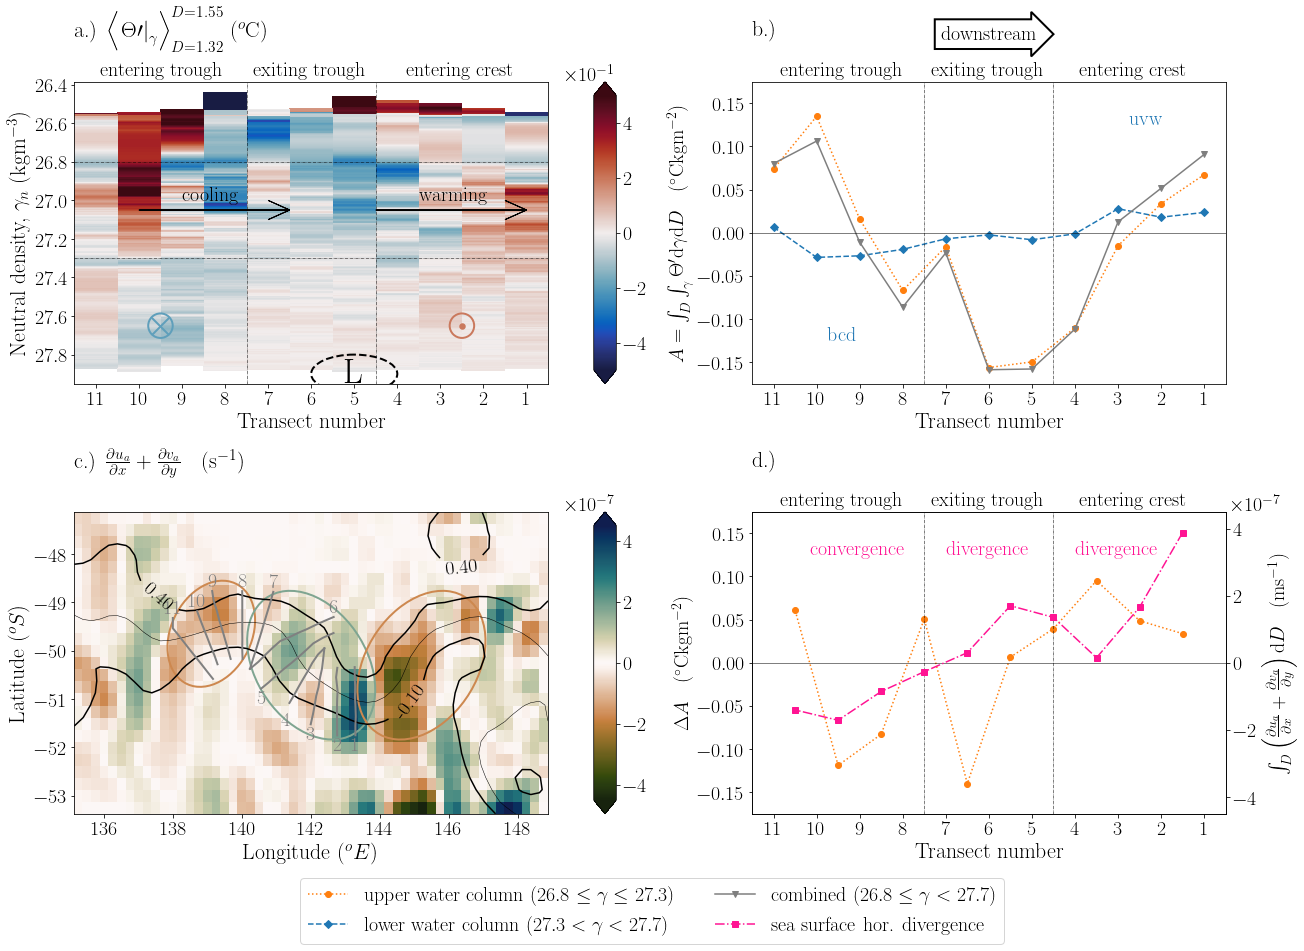

In [15]:
vmin, vmax = -4.5e-7, 4.5e-7
ssh_contours = np.linspace(-0.1, 0.4, 3)

fig, ax = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)
# fig.tight_layout()

# Upper-left Panel
var='CT'
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)
pcol = ax[0, 0].pcolormesh(x, gni, avg_CT_prime_gn.T, 
                        cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1], shading='auto')

cbar = plt.colorbar(pcol, ax=ax[0, 0], extend='both')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax[0, 0].set_yticks(np.linspace(26.4, 28.0, 9))

# # Cones
# # warm cone
# poly = Polygon([[11.5, 26.8], [11.5, 26.9], [10.5, 27.25], [10, 27.3], [9.5, 27.25], [8.5, 26.9], [7.5, 26.8]], 
#                closed=True, fill=False, hatch='/')
# poly.set_edgecolor(cmo.cm.balance(178))
# ax[0, 0].add_patch(poly)

# # cold cone
# poly = Polygon([[8.5, 27.3], [7.5, 27.18], [6.5, 26.9], [5.5, 26.8], [4.5, 26.8], 
#                 [3.5, 26.9], [2.5, 27.1], [1.5, 27.25], [0.5, 27.3]], closed=True,
#                       fill=False, hatch='/')
# poly.set_edgecolor(cmo.cm.balance(78))
# ax[0, 0].add_patch(poly)

# Add vector symbols

# # upper water column
# arrow_up = Arrow(x=10, y=26.95, dx=0, dy=0.25, width=1)
# arrow_up.set_facecolor(cmo.cm.balance(178))
# arrow_up.set_edgecolor(cmo.cm.balance(256))
# ax[0, 0].add_artist(arrow_up)

# arrow_down = Arrow(x=5, y=27.2, dx=0, dy=-0.25, width=1)
# arrow_down.set_facecolor(cmo.cm.balance(78))
# arrow_down.set_edgecolor(cmo.cm.balance(0))
# ax[0, 0].add_artist(arrow_down)

ax[0, 0].arrow(x=10, y=27.05, dx=-3, dy=0, head_width=0.1, head_length=0.5, width=0.0001, overhang=1)
ax[0, 0].text(x=9, y=27, s='cooling')
ax[0, 0].arrow(x=4.5, y=27.05, dx=-3, dy=0, head_width=0.1, head_length=0.5, width=0.0001, overhang=1)
ax[0, 0].text(x=3.5, y=27, s='warming')

# lower water column
circ = ax[0, 0].scatter(9.5, 27.65, s=600, edgecolors=cmo.cm.balance(78), facecolors='none', marker='o', linewidths=2)
cross = ax[0, 0].scatter(9.5, 27.65, s=300, color=cmo.cm.balance(78), marker='x', linewidths=2)

circ = ax[0, 0].scatter(2.5, 27.65, s=600, edgecolors=cmo.cm.balance(178), facecolors='none', marker='o', linewidths=2)
dot = ax[0, 0].scatter(2.5, 27.65, s=20, edgecolors=cmo.cm.balance(178), facecolors=cmo.cm.balance(178), marker='o', linewidths=2)

low = ax[0, 0].text(5, 27.9, 'L', ha='center', va='center', size='xx-large', weight='bold')
ellps = Ellipse(xy=(5, 27.9), width=2, height=0.2, lw=2, fill=False, ls='dashed') #, fc=cmo.cm.tarn(78, 0.1)
ax[0, 0].add_artist(ellps)

# Upper-right Panel
for n, key in enumerate(list(attrs.keys())[:-1]):
    print(key, attrs[key][3])
    A = [i[n] for i in tot_CT_prime_gn.values()]
    ax[0, 1].plot(x, A, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2], label=key%attrs[key][3])
ax[0, 1].set_ylabel(r"$A = \int_D\int_\gamma\Theta'\mathrm{d}\gamma\mathrm{d}D \quad \mathrm{(^\circ C kgm^{-2})}$")

ax[0, 1].text(9.75, -0.125, 'bcd', color='tab:blue')
ax[0, 1].text(2.75, 0.125, 'uvw', color='tab:blue')


# Lower-left panel
# manual = [(144, -52), (144, -51.5), (145, -51), (145, -50), (145, -48.6)]
pcol = ax[1, 0].pcolor(qgvb.longitude, qgvb.latitude, qgvb.divag.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.tarn)
cbar = plt.colorbar(pcol, ax=ax[1, 0], extend='both')
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# plot steamlines
ct = ax[1, 0].contour(ssh.longitude, ssh.latitude,
                   ssh.adt.sel(time=timevoy).mean('time'),
                   ssh_contours, colors='k', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(ssh_contours):
    if b in ssh_contours[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax[1, 0].clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')
# ax.clabel(ct, [Dmin, Dmax], inline=1, fontsize=10, fmt='%.2f')

# plot transects and numbers
for transect in transects.keys():
    istations = np.array(transects[transect])
    ax[1, 0].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0],
               '-', color='gray', lw=2)
ts = {1:2, 2:17, 3:18, 4:34, 5:36, 6:46, 7:64, 8:75, 9:76, 10:90, 11:93}
for its in ts.keys():
    spacing = 0.2 if its > 5 else -0.2
    ax[1, 0].text(s=str(its), x=ctd['lon'][ts[its],0], y=ctd['lat'][ts[its],0]+spacing, 
                  color='gray', ha='center', va='center')


# plot Ellipse 1
ellps = Ellipse(xy=(139.1, -49.65), width=2.7, height=2, angle=30, 
                ec=cmo.cm.tarn(78), lw=2, fill=False) #, fc=cmo.cm.tarn(78, 0.1)
ax[1, 0].add_artist(ellps)

# plot Ellipse 2
ellps = Ellipse(xy=(142, -50.3), width=4, height=2.7, angle=-30, 
                ec=cmo.cm.tarn(178), lw=2, fill=False)
ax[1, 0].add_artist(ellps)

# plot Ellipse 3
ellps = Ellipse(xy=(145.2, -50.3), width=4, height=2.7, angle=30,
                ec=cmo.cm.tarn(78), lw=2, fill=False)
ax[1, 0].add_artist(ellps)

ax[1, 0].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax[1, 0].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)


# Lower-right panel

### left y-axis
for n, key in enumerate(list(attrs.keys())[0:1]):
    dx = [x[i] + (x[i+1] - x[i])/2 for i in range(len(x)-1)]
    A = [i[n] for i in tot_CT_prime_gn.values()]
    dA = np.flip([A[i] - A[i+1] for i in reversed(range(len(A)-1))])

    ax[1, 1].plot(dx, dA, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2])#, label=key
ax[1, 1].set_ylabel(r"$\Delta A \quad \mathrm{(^\circ C kgm^{-2})}$")

### right y-axis
key = 'sea surface hor. divergence'
ax2 = ax[1, 1].twinx()
s = [i[3] for i in tot_CT_prime_gn.values()]
si = np.interp(dx, x, s)
ax2.plot(dx, si, color=attrs[key][0], linestyle=attrs[key][1], marker=attrs[key][2], label=key)
ax2.set_ylim(-4.5e-7, 4.5e-7)
ax2.yaxis.offsetText.set_position((1.12, 1))
ax2.set_ylabel(r"$\int_D \left(\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}\right) \mathrm{d}D \quad \mathrm{(ms^{-1})}$")
ax[1, 1].set_xlim([0.5, 11.5])
ax[1, 1].text(10.15, 0.125, 'convergence', color='deeppink')
ax[1, 1].text(7, 0.125, 'divergence', color='deeppink')
ax[1, 1].text(4, 0.125, 'divergence', color='deeppink')

# Formatting axes
cbar_labels = [r'$\left <\left.\Theta\prime\right|_{\gamma} \right >_{D=%s}^{D=%s}$ ($^o$C)' %(round(Dmin,2), round(Dmax,2)),
               r'$\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}  \quad \mathrm{(s^{-1})}$']

iax = 0
row, col = ax.shape
for r in range(row):
    for c in range(col):
        if (r, c) != (1, 0):
            ax[r, c].set_xticks(x)
            ax[r, c].set_xlabel('Transect number', fontsize=fs_large)
            ax[r, c].invert_xaxis()
            ax[r, c].axvline(7.5, color='k', linestyle='-.', lw=0.5)
            ax[r, c].axvline(4.5, color='k', linestyle='-.', lw=0.5)
        if c == 1:
            ax[r, c].axhline(color='k', lw=0.5)
            ax[r, c].set_ylim(-0.175, 0.175)
            ax[r, c].text(11.25 - 0.4, 0.182, 'entering trough')
            ax[r, c].text(7.35, 0.182, 'exiting trough')
            ax[r, c].text(3.7 + 0.2, 0.182, 'entering crest')
        if c == 0:
            ax[r, c].text(0, 1.15, string.ascii_lowercase[iax] + '.) ' + cbar_labels[r], transform=ax[r, c].transAxes, 
                          size=fs_large, weight='bold')
        else:
            ax[r, c].text(0, 1.15, string.ascii_lowercase[iax] + '.)', transform=ax[r, c].transAxes, 
                          size=fs_large, weight='bold')
        iax+=1

ax[0, 1].text(6, 0.23, "downstream", ha="center", va="center", size=fs_small,
              bbox=dict(boxstyle="rarrow,pad=0.3", fc="none", ec="k", lw=2))        
ax[0, 0].invert_yaxis()
ax[0, 0].text(10.9, 26.35, 'entering trough', fontsize=fs_small)
ax[0, 0].text(7.35, 26.35, 'exiting trough', fontsize=fs_small)
ax[0, 0].text(3.8, 26.35, 'entering crest', fontsize=fs_small)
ax[0, 0].axhline(26.8, color='k', linestyle='-.', linewidth=0.5)
ax[0, 0].axhline(27.3, color='k', linestyle='-.', linewidth=0.5)
ax[0, 0].set_ylabel(r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', fontsize=fs_large)

# fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=2)


In [16]:
if savefig:
    fignumber = '09_'
    figname = 'summary-cyclogenesis'
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), 
                    transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
